/var/folders/sb/krtdqwds3lg0vghh1l417sr00000gn/T/ipykernel_16243/4261444869.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


Logistic Regression - Accuracy: 98.39%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2054
           1       0.98      0.96      0.97       685

    accuracy                           0.98      2739
   macro avg       0.98      0.98      0.98      2739
weighted avg       0.98      0.98      0.98      2739

                              MAE           MSE         RMSE        R2
RandomForest           202.798830  1.372095e+05   370.418041  0.999059
GradientBoosting       261.294543  1.896795e+05   435.522044  0.998699
HistGradientBoosting   313.137483  8.180611e+05   904.467329  0.994390
Ridge                 4830.921699  4.776639e+07  6911.323370  0.672429
Lasso                 4831.317771  4.776575e+07  6911.277315  0.672433


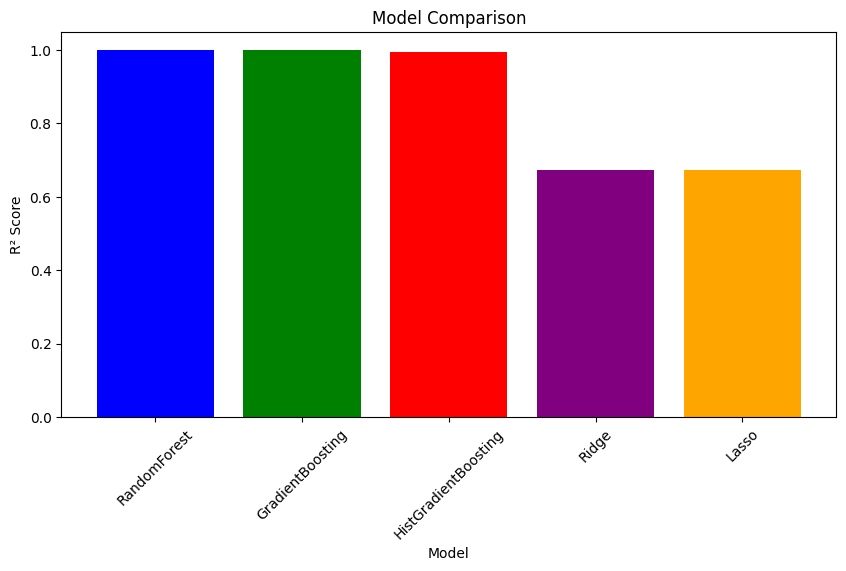

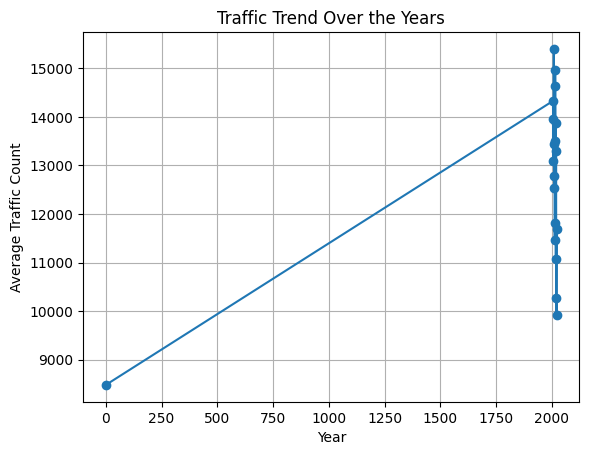

/var/folders/sb/krtdqwds3lg0vghh1l417sr00000gn/T/ipykernel_16243/4261444869.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['day_of_week'] == i]["total_count"] for i in range(7)], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


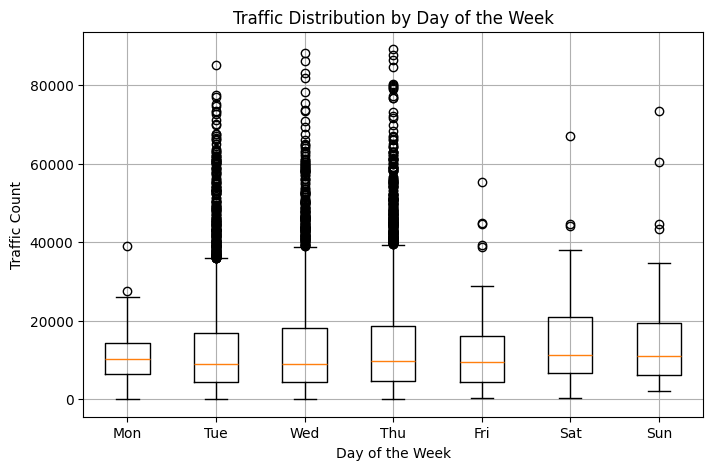

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Load the dataset
file_path = "traffic_counts_datasd.csv"  # Ensure this file is in the same directory
df = pd.read_csv(file_path)

# Convert date to datetime format and extract features
df["date_count"] = pd.to_datetime(df["date_count"], errors="coerce")
df["year"] = df["date_count"].dt.year
df["month"] = df["date_count"].dt.month
df["day_of_week"] = df["date_count"].dt.dayofweek
df["hour"] = df["date_count"].dt.hour

# Fill missing values
df.fillna(0, inplace=True)

# Convert numeric columns properly
numeric_cols = ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "total_count"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Check categorical columns
categorical_cols = [col for col in ["street", "cross_street"] if col in df.columns]

# Select features and target
features = ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "year", "month", "day_of_week", "hour"] + categorical_cols
target = "total_count"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("power", PowerTransformer(method='yeo-johnson'))
        ]), ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "year", "month", "day_of_week", "hour"]),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols) if categorical_cols else ("cat", "passthrough", [])
    ]
)

# Model definitions
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

# Evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

# Logistic Regression Classification
y_train_class = (y_train > y_train.quantile(0.75)).astype(int)
y_test_class = (y_test > y_test.quantile(0.75)).astype(int)

logreg = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(solver='liblinear', max_iter=200))])
logreg.fit(X_train, y_train_class)

y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test_class, y_pred_logreg)
print(f"Logistic Regression - Accuracy: {accuracy_logreg:.2%}")
print(classification_report(y_test_class, y_pred_logreg))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
print(results_df)

# Visualize performance
plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df["R2"], color=["blue", "green", "red", "purple", "orange"])
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.show()

# Traffic trend analysis
df.groupby("year")["total_count"].mean().plot(marker='o', linestyle='-', title="Traffic Trend Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Traffic Count")
plt.grid(True)
plt.show()

# Traffic distribution by day of the week
plt.figure(figsize=(8, 5))
plt.boxplot([df[df['day_of_week'] == i]["total_count"] for i in range(7)], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Traffic Count")
plt.title("Traffic Distribution by Day of the Week")
plt.grid(True)
plt.show()







